In [0]:
# Clasificador de BF con Chalearn en BN y Keras
# Miguelangel Moreno Sotelo

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import random
import time
import pickle
import keras
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model
from keras import backend as K
from keras.models import model_from_json
from keras import optimizers
from keras import losses
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from PIL import Image,ImageOps

Using TensorFlow backend.


## DataSet

In [2]:
class DataSet:
    data_train = None;
    data_test  = None;
    
    # 30935 total
    total_train = 28152;
    total_test  =  2783;
       
    
    def read_pickle(self, name, show=False):
        
        if show:
            print('Cargando pickle',"../DataSet/{}.pickle".format(name));
        pic = pickle.load(open("../DataSet/{}.pickle".format(name), "rb"));
        
        X = np.array(pic['X']);   
        Y = np.array(pic['Y']);
        
        if show:
           print('X-',X.shape)
           print('Y-',Y.shape)        
                
        return X,Y;
                         
        
    def load_dataset(self):
        self.data_train = dict(X=[],Y=[]);
        self.data_test  = dict(X=[],Y=[]);
        
        for i in range(1,4):
            x,y = self.read_pickle('train_clselfie_v4_{}'.format(i), show=True);
            self.data_train['X'].extend(x);
            self.data_train['Y'].extend(y);
        
        x,y = self.read_pickle('test_clselfie_v4', show=True);
        self.data_test['X'].extend(x);
        self.data_test['Y'].extend(y);
           
        
        
        self.data_train['X'] = np.array(self.data_train['X']);        
        self.data_train['Y'] = np.array(self.data_train['Y']);
                
        self.data_test['X'] = np.array(self.data_test['X']);
        self.data_test['Y'] = np.array(self.data_test['Y']);     
       
        
        
        
        print('\nTotal Train Data X:',self.data_train['X'].shape,'Y:',self.data_train['Y'].shape);
        print('\nTotal Test  Data X:',self.data_test['X'].shape,'Y:',self.data_test['Y'].shape);    
        
        

        

In [3]:
# Cargamos Dataset
ds = DataSet();
ds.load_dataset();

Cargando pickle ../DataSet/train_clselfie_v4_1.pickle
X- (9000, 208, 208, 1)
Y- (9000, 5)
Cargando pickle ../DataSet/train_clselfie_v4_2.pickle
X- (9000, 208, 208, 1)
Y- (9000, 5)
Cargando pickle ../DataSet/train_clselfie_v4_3.pickle
X- (10152, 208, 208, 1)
Y- (10152, 5)
Cargando pickle ../DataSet/test_clselfie_v4.pickle
X- (2783, 208, 208, 1)
Y- (2783, 5)

Total Train Data X: (28152, 208, 208, 1) Y: (28152, 5)

Total Test  Data X: (2783, 208, 208, 1) Y: (2783, 5)


Y [0.72222222 0.60194175 0.57943925 0.50549451 0.59375   ]


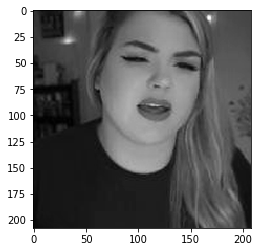

Y [0.66666667 0.51456311 0.44859813 0.65934066 0.54166667]


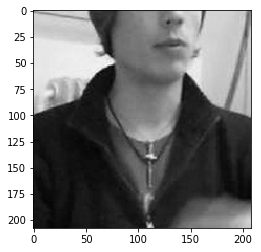

Y [0.51111111 0.3592233  0.3364486  0.41758242 0.27083333]


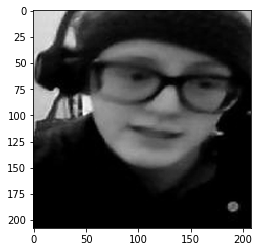

Y [0.32222222 0.18446602 0.18691589 0.17582418 0.13541667]


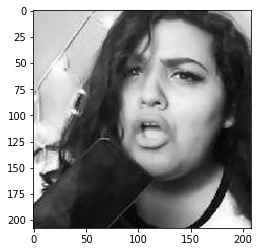

Y [0.34444444 0.37864078 0.22429907 0.37362637 0.40625   ]


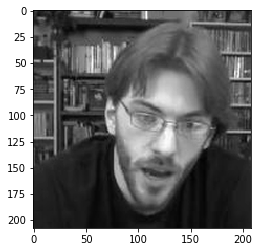

Y [0.26666667 0.33980583 0.30841121 0.42857143 0.34375   ]


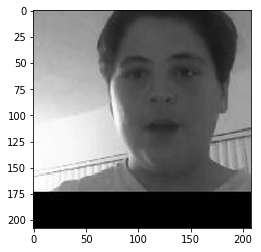

Y [0.73333333 0.69902913 0.69158879 0.73626374 0.6875    ]


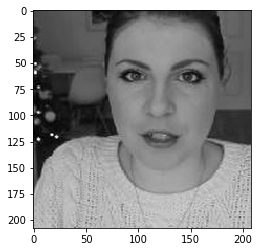

Y [0.72222222 0.69902913 0.72897196 0.71428571 0.67708333]


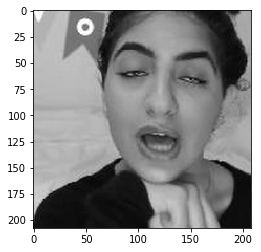

Y [0.8        0.85436893 0.68224299 0.52747253 0.72916667]


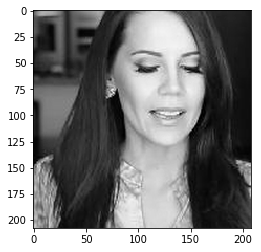

Y [0.67777778 0.6407767  0.53271028 0.61538462 0.44791667]


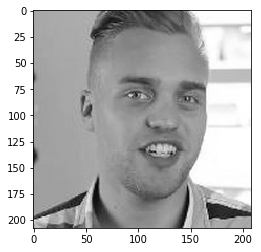

Y [0.17777778 0.33980583 0.19626168 0.30769231 0.20833333]


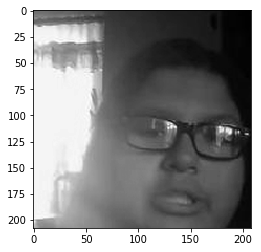

Y [0.47777778 0.66990291 0.31775701 0.6043956  0.61458333]


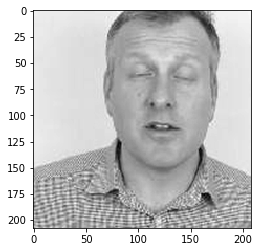

Y [0.44444444 0.68932039 0.18691589 0.47252747 0.46875   ]


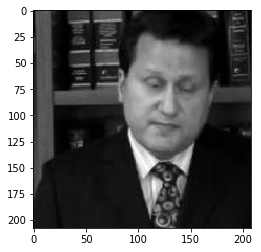

Y [0.61111111 0.48543689 0.31775701 0.3956044  0.47916667]


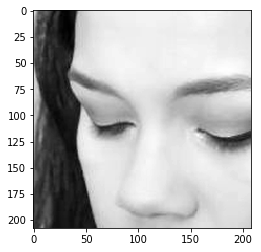

Y [0.7        0.63106796 0.60747664 0.57142857 0.66666667]


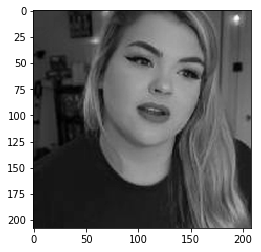

Y [0.52222222 0.5631068  0.42056075 0.45054945 0.58333333]


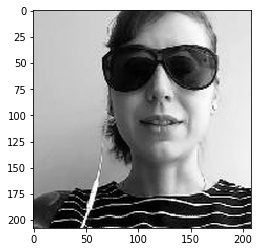

Y [0.66666667 0.39805825 0.58878505 0.42857143 0.70833333]


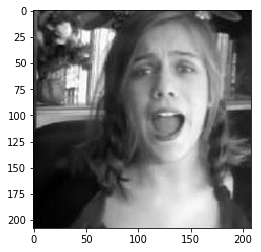

Y [0.63333333 0.60194175 0.5046729  0.74725275 0.52083333]


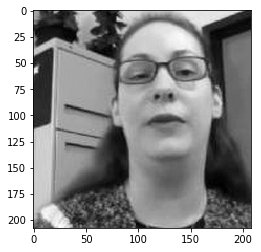

Y [0.88888889 0.68932039 0.70093458 0.61538462 0.77083333]


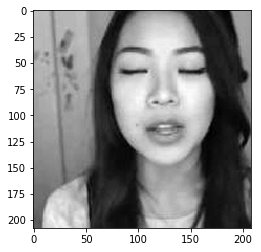

Y [0.48888889 0.50485437 0.55140187 0.51648352 0.44791667]


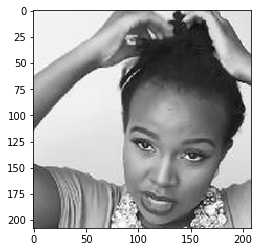

Y [0.8        0.54368932 0.64485981 0.45054945 0.69791667]


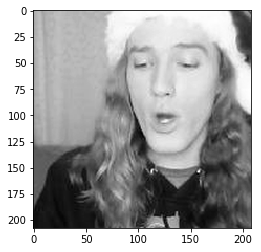

Y [0.33333333 0.59223301 0.35514019 0.2967033  0.4375    ]


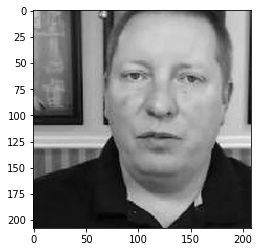

Y [0.45555556 0.40776699 0.38317757 0.47252747 0.41666667]


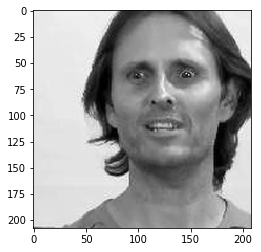

Y [0.45555556 0.4368932  0.41121495 0.46153846 0.53125   ]


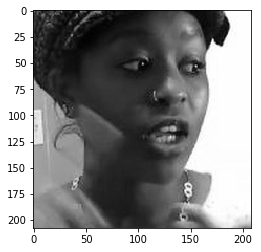

Y [0.62222222 0.63106796 0.62616822 0.59340659 0.60416667]


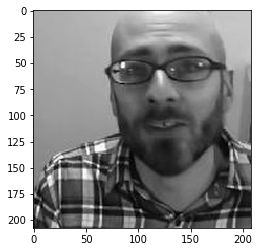

Y [0.47777778 0.38834951 0.36448598 0.42857143 0.32291667]


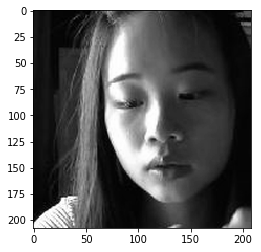

Y [0.42222222 0.68932039 0.22429907 0.62637363 0.4375    ]


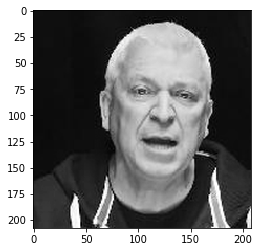

Y [0.64444444 0.45631068 0.51401869 0.56043956 0.5       ]


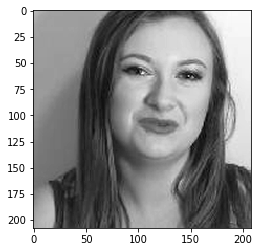

Y [0.6        0.38834951 0.60747664 0.51648352 0.54166667]


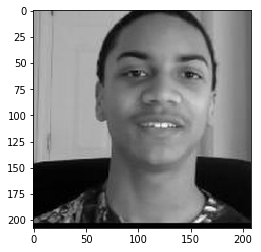

Y [0.33333333 0.33009709 0.40186916 0.46153846 0.3125    ]


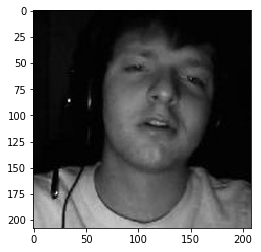

In [4]:
for i in range(0,15):
    print('Y',ds.data_test['Y'][i])
    plt.imshow(ds.data_test['X'][i].reshape(208,208), cmap='gray')
    plt.show();
    
for i in range(0,15):
    print('Y',ds.data_train['Y'][i])
    plt.imshow(ds.data_train['X'][i].reshape(208,208), cmap='gray')
    plt.show();

## Modelo y Entrenamiento

In [5]:
def save_model(index=0):
    name = 'cnn2_train';
    model_json = classifier.to_json()
    with open("{}_{}.json".format(name, index), "w") as json_file:
        json_file.write(model_json)
    classifier.save_weights("{}_{}.h5".format(name,index),)
    print("Modelo guardado en disco","{}_{}.h5".format(name,index))

In [48]:
input_cla = Input(shape=(208,208,1,))

fm_size = 16;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(input_cla)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

fm_size = fm_size*2;
x = Conv2D(fm_size, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

em_size = math.ceil(208/(2**8));

x = Reshape((em_size*em_size*fm_size,),input_shape=(em_size,em_size,fm_size))(x)
x=Dense(50,activation='relu', input_shape=(em_size*em_size*fm_size,))(x)
x=Dense(50,activation='relu')(x)
x=Dense(10,activation='relu')(x)
# x=Dense(500,activation='relu')(x)
# x=Dense(500,activation='relu')(x)
# x=Dense(500,activation='relu')(x)
# x=Dense(100,activation='relu')(x)
# x=Dense(100,activation='relu')(x)
output=Dense(5)(x)


adam = optimizers.adam(lr=1e-6)
classifier = Model(input_cla, output)
classifier.compile(optimizer=adam, loss=losses.mse)
# classifier.compile(optimizer=adam, loss=my_loss)

classifier.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 208, 208, 1)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 208, 208, 16)      160       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 104, 104, 16)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 104, 104, 32)      4640      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 52, 52, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 26, 26, 64)        0         
__________

In [8]:
def my_loss(y_true, y_pred):
    mean  = K.variable(value=0.55, dtype='float32');
    alpha = K.variable(value=10, dtype='float32');
    
    return K.mean(K.sum((K.abs(y_true-y_pred)) * (alpha * (K.abs(y_true-mean) + 1)), axis=1))

In [46]:
save = 2;

In [31]:

global_history = {'val_loss':[], 'loss':[], 'mean_acc':[]}
best_acc = 0;

In [50]:
for i in range(0,80):
    h = classifier.fit(ds.data_train['X'], ds.data_train['Y'],
                epochs=1,
                batch_size=100,
                shuffle=False,
                validation_data=(ds.data_test['X'], ds.data_test['Y']))

    global_history['val_loss'].extend(h.history['val_loss'])
    global_history['loss'].extend(h.history['loss'])
    
    mean_acc = get_global_evaluation();
    global_history['mean_acc'].append(mean_acc);
    
    print('Mean-acc:',mean_acc)
    
    if mean_acc > best_acc:
        best_acc = mean_acc;
        save_model(index=save);

Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 30s 1ms/step - loss: 0.0044 - val_loss: 0.0236
Mean-acc: 0.8768618659939265
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 28s 1ms/step - loss: 0.0041 - val_loss: 0.0237
Mean-acc: 0.8765379621158973
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 28s 1ms/step - loss: 0.0039 - val_loss: 0.0238
Mean-acc: 0.8763685326206438
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 28s 1ms/step - loss: 0.0037 - val_loss: 0.0239
Mean-acc: 0.8762333437035567
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 28s 1ms/step - loss: 0.0036 - val_loss: 0.0239
Mean-acc: 0.8761228167790159
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==================

28152/28152 [==============================] - 29s 1ms/step - loss: 0.0016 - val_loss: 0.0247
Mean-acc: 0.8741986190401526
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 28s 1ms/step - loss: 0.0016 - val_loss: 0.0247
Mean-acc: 0.8741584724880644
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 29s 1ms/step - loss: 0.0016 - val_loss: 0.0248
Mean-acc: 0.8741036375700938
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 28s 1ms/step - loss: 0.0016 - val_loss: 0.0248
Mean-acc: 0.8740559085504149
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 29s 1ms/step - loss: 0.0015 - val_loss: 0.0248
Mean-acc: 0.8740145737838085
Train on 28152 samples, validate on 2783 samples
Epoch 1/1
28152/28152 [==============================] - 29s 1ms/step - loss: 0.0015 - val_loss: 0.0

KeyboardInterrupt: 

In [49]:
classifier.load_weights("cnn2_train_1.h5")
print("Modelo cargado desde disco ")

Modelo cargado desde disco 


In [84]:
print(global_history['mean_acc'])

[66.91160877373481, 67.69002950632422, 68.24004761875445, 68.5606999481342, 68.99617072749213, 69.48285057305755, 70.12501350943636, 70.6897605001755, 71.16782937776154, 71.98173899268674, 72.58225037660885, 72.94913573592703, 72.52901494674259, 71.96817660820692, 74.01805135003404, 74.29103028105726, 74.64499450534088, 74.74382731258684, 75.06873267227503, 80.63346064098809, 84.60509271167808, 86.69586048430027, 87.46564931975679, 88.15953723313278, 87.82809583350357, 87.21897006124571, 88.01251322471234, 88.26425826493765, 87.98504325205761, 86.48844297002111, 85.904769841837, 86.45470731602352, 87.4961411603542, 88.18587889005778, 88.37471882580819, 88.36281808211878, 87.67401040762742, 86.84724472305513, 86.61396398443803, 86.87794238486966, 87.05044333235938, 87.1806319665953, 87.80422262847323, 87.66456633521373, 87.8627067251909, 87.9695648153614, 87.97435675407193, 87.99151621267947, 87.99462744680842, 87.91135350666114, 88.3172858906882, 88.04673794692327, 88.23583505894247, 8

In [61]:
print(global_history['loss'])

[0.1759505603069709, 0.1685684249927185, 0.16357284102776268, 0.1587350210574548, 0.15407526993800646, 0.14949784682373934, 0.14507468171369017, 0.14058862234439048, 0.13632056623502495, 0.13216120288893898, 0.1281328845190101, 0.12427522263982717, 0.12072884235409351, 0.11811241750801514, 0.11495333977422616, 0.11117669475259818, 0.10793870955421932, 0.10566048922335333, 0.10224032381077862, 0.07441639869507485, 0.035389743585210444, 0.021184956291534322, 0.016499740614006088, 0.01512586917097247, 0.014152341157581173, 0.01374976742394961, 0.01344120978640033, 0.014387777895206424, 0.01433444372279044, 0.013857786893144855, 0.01358991921645131, 0.013428924879036436, 0.013347722792298736, 0.012945458423303937, 0.012351884607608877, 0.011807173824651815, 0.012073336058365339, 0.012577226846239365, 0.011832160808309558, 0.011088105874931645, 0.010508817303385855, 0.010094400513618146, 0.010179540388083387, 0.011320926735530158, 0.010611950450940214, 0.00948499636818544, 0.008686166864778

In [63]:
print(global_history['val_loss'])

[0.17784540435520813, 0.1731927294365759, 0.1690347367456565, 0.1650098887785193, 0.16087415907565442, 0.1569154692711352, 0.15257152286935444, 0.1485413286461489, 0.14488698666339037, 0.14118094796912514, 0.13793683725640452, 0.13472010306625798, 0.13201042233912413, 0.1313951079296286, 0.1250683883866988, 0.12202907126882802, 0.11951647234656937, 0.11710466967077081, 0.11254913690243956, 0.060636641598897915, 0.03929762386302275, 0.03028326474486218, 0.02717028755428249, 0.024729410877790632, 0.02628725571567919, 0.028892614031722552, 0.025610942457124263, 0.024390126342583678, 0.025140978003063308, 0.03128705909151076, 0.033667336639379625, 0.031194805807125813, 0.027045706328522632, 0.02447552150674231, 0.023833424437214177, 0.024149096358408183, 0.02741096369009244, 0.030819096588109666, 0.03178013349704892, 0.030623670984655245, 0.02988676913283388, 0.029310135233061717, 0.02643469232427337, 0.026279921408848415, 0.025577901312067403, 0.02523346195225659, 0.02526476559407562, 0.0

In [36]:
%matplotlib inline

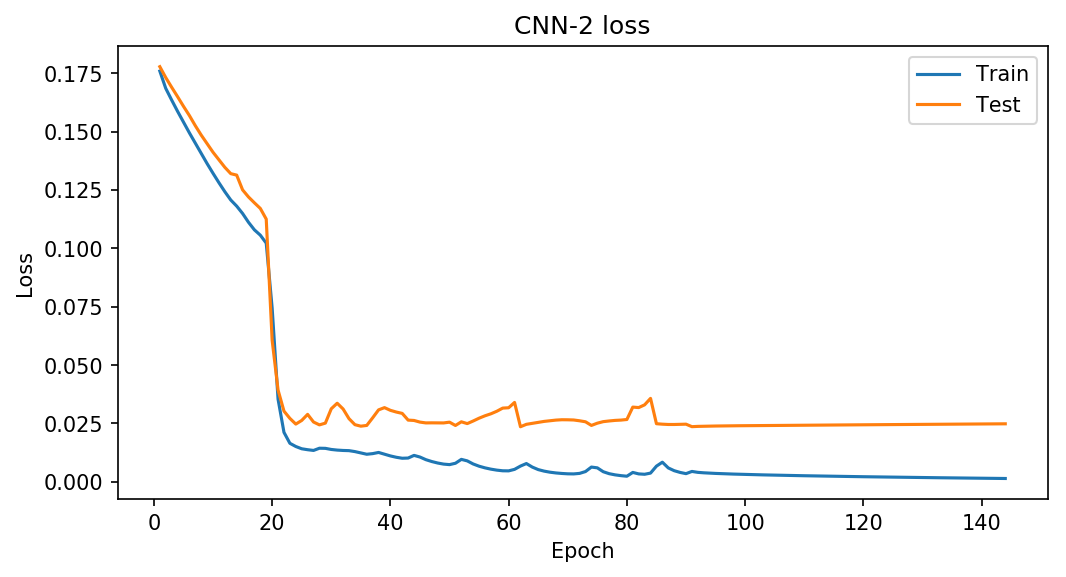

In [85]:
# Plot training & validation loss values
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)
x = np.arange(1,145,1);

axes.plot(x, global_history['loss'][0:200])
axes.plot(x, global_history['val_loss'][0:200])

plt.title('CNN-2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')


fig.savefig("cnn2-full.png",dpi=150) 

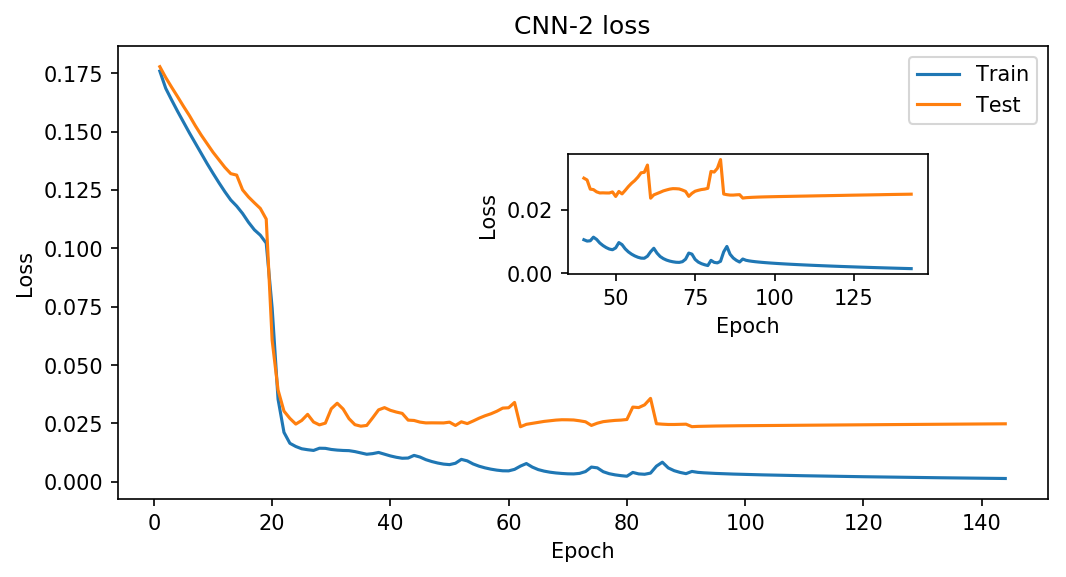

In [86]:
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)

x = np.arange(1,145,1);
axes.plot(x, global_history['loss'][0:200])
axes.plot(x, global_history['val_loss'][0:200])
plt.title('CNN-2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

zoom_init = 40;
x = np.arange(zoom_init,144,1);
axes2=fig.add_axes([0.5,0.5,0.3,0.2])
axes2.plot(x, global_history['loss'][zoom_init:200])
axes2.plot(x, global_history['val_loss'][zoom_init:200])
axes2.set_xlabel("Epoch")
axes2.set_ylabel("Loss")

fig.savefig("cnn2-mix.png",dpi=150) 

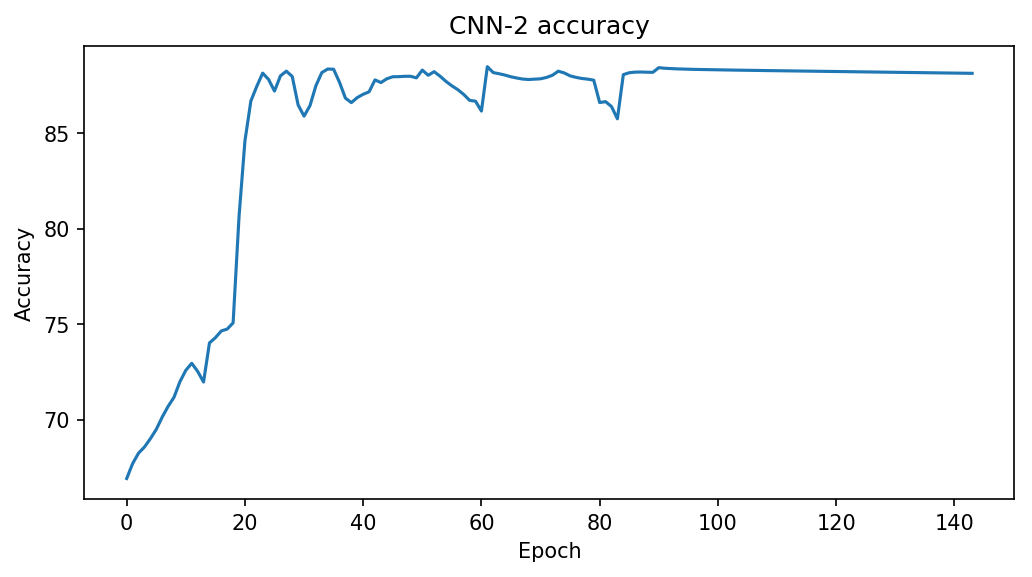

In [87]:
# Plot ACC
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)

x = np.arange(1,81,1);
axes.plot(global_history['mean_acc'][0:200])
plt.title('CNN-2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


fig.savefig("cnn2-acc.png",dpi=150) 

In [89]:
def test_regresor_per_factor(index=0, show=False):
    # Test como regresor
    tolerance_i = 0.1;
    X = ds.data_test['X'];
    Y = ds.data_test['Y'];
    out = classifier.predict(X)

    acc = 0;
    diff = 0;
    for i in range(out.shape[0]):         
        diff = diff + (1 - abs(Y[i][index]-out[i][index]));

    acc = diff / (out.shape[0] * 1);
    acc = acc *100;
    
    if show:
        print('Acc CL',acc);
    acc1 = acc;


    acc = 0;
    diff = 0;
    for i in range(out.shape[0]):  
        diff = abs(Y[i][index]-out[i][index]); 

        if diff<=tolerance_i:
            acc = acc + 1;

    acc = acc / (out.shape[0] * 1);
    acc = acc *100;

    if show:
        print('Acc uno tol',acc);   
    
    return (acc1,acc);

def get_global_evaluation(show=False):

    prom_cl = 0;
    prom_to = 0;
    
    if show:
        print('O');
    (a1,a2) = test_regresor_per_factor(index=0, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nC');
    (a1,a2) = test_regresor_per_factor(index=1, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nE');
    (a1,a2) = test_regresor_per_factor(index=2, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nA');
    (a1,a2) = test_regresor_per_factor(index=3, show=show);
    prom_cl += a1;
    prom_to += a2;

    if show:
        print('\nN');
    (a1,a2) = test_regresor_per_factor(index=4, show=show);
    prom_cl += a1;
    prom_to += a2;

    prom_cl = prom_cl/5;
    prom_to = prom_to/5;

    if show:
        print('\nPromedio');
        print('ChaLearn',prom_cl)
        print('Uno tol', prom_to)
        
    return prom_cl;

get_global_evaluation(show=True)

O
Acc CL 88.00807749098976
Acc uno tol 49.838303988501615

C
Acc CL 86.70029899849546
Acc uno tol 44.125044915558746

E
Acc CL 87.43354759820632
Acc uno tol 47.64642472152353

A
Acc CL 87.89061456416822
Acc uno tol 48.07761408551922

N
Acc CL 86.87988243598195
Acc uno tol 46.53251886453467

Promedio
ChaLearn 87.38248421756835
Uno tol 47.243981315127556


87.38248421756835

In [25]:
# Matriz de confusion Regresor
Y = ds.data_test['Y'][:];
tar = np.zeros(Y.shape)
out = classifier.predict(ds.data_test['X'][:])

# Preparo datos para la matriz
#  0: 0.00-0.05
#  1: 0.06-0.15
#  2: 0.16-0.25
#  3: 0.26-0.35
#  4: 0.36-0.45
#  5: 0.46-0.55
#  6: 0.56-0.65
#  7: 0.66-0.75
#  8: 0.76-0.85
#  9: 0.86-0.95
# 10: 0.96-1.00

for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        
        if Y[i][j]>=0.00 and Y[i][j]<=0.05:
            tar[i][j] = 0.0;
        elif Y[i][j]>0.05 and Y[i][j]<=0.15:
            tar[i][j] = 0.1;
        elif Y[i][j]>0.15 and Y[i][j]<=0.25:
            tar[i][j] = 0.2;
        elif Y[i][j]>0.25 and Y[i][j]<=0.35:
            tar[i][j] = 0.3;
        elif Y[i][j]>0.35 and Y[i][j]<=0.45:
            tar[i][j] = 0.4;
        elif Y[i][j]>0.45 and Y[i][j]<=0.55:
            tar[i][j] = 0.5;
        elif Y[i][j]>0.55 and Y[i][j]<=0.65:
            tar[i][j] = 0.6;
        elif Y[i][j]>0.65 and Y[i][j]<=0.75:
            tar[i][j] = 0.7;
        elif Y[i][j]>0.75 and Y[i][j]<=0.85:
            tar[i][j] = 0.8;
        elif Y[i][j]>0.85 and Y[i][j]<=0.95:
            tar[i][j] = 0.9;
        elif Y[i][j]>0.95 and Y[i][j]<=1.00:
            tar[i][j] = 1.0;
        

for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        
        if out[i][j]>=0.00 and out[i][j]<=0.05:
            out[i][j] = 0.0;
        elif out[i][j]>0.05 and out[i][j]<=0.15:
            out[i][j] = 0.1;
        elif out[i][j]>0.15 and out[i][j]<=0.25:
            out[i][j] = 0.2;
        elif out[i][j]>0.25 and out[i][j]<=0.35:
            out[i][j] = 0.3;
        elif out[i][j]>0.35 and out[i][j]<=0.45:
            out[i][j] = 0.4;
        elif out[i][j]>0.45 and out[i][j]<=0.55:
            out[i][j] = 0.5;
        elif out[i][j]>0.55 and out[i][j]<=0.65:
            out[i][j] = 0.6;
        elif out[i][j]>0.65 and out[i][j]<=0.75:
            out[i][j] = 0.7;
        elif out[i][j]>0.75 and out[i][j]<=0.85:
            out[i][j] = 0.8;
        elif out[i][j]>0.85 and out[i][j]<=0.95:
            out[i][j] = 0.9;
        elif out[i][j]>0.95 and out[i][j]<=1.00:
            out[i][j] = 1.0;

# Construccion de la matriz
matrix = np.zeros((11,11))

for i in range(out.shape[0]):
#     print(tar[i])
#     print(out[i],'\n')
    
    for j in range(out.shape[1]):
        
        mi = int(round(out[i][j] * 10));
        mj = int(round(tar[i][j] * 10));        
        
        if mi==11:
            mi = 10;
        
        matrix[mi][mj] += 1;
        
# Imprimimos con formato
just = 6;
header = '----'
header += repr(0.0).rjust(just)
header += repr(0.1).rjust(just)
header += repr(0.2).rjust(just)
header += repr(0.3).rjust(just)
header += repr(0.4).rjust(just)
header += repr(0.5).rjust(just)
header += repr(0.6).rjust(just)
header += repr(0.7).rjust(just)
header += repr(0.8).rjust(just)
header += repr(0.9).rjust(just)
header += repr(1.0).rjust(just)
print(header)

row_count = 0.0;

for i in range(matrix.shape[0]):
    row = str(i/10);
    
    for j in range(matrix.shape[1]):        
        row += repr(int(matrix[i][j])).rjust(just)
        
    row += repr(int(sum(matrix[i]))).rjust(just)
    
    print(row)
    row_count += 0.1;

row = '---';
for i in range(matrix.shape[1]):
    row += repr(int(sum(matrix[:,i]))).rjust(just)
print(row)

success = 0;
for i in range(0,11):
    success += matrix[i][i]
    
print('\n\nCorrectos',int(success))
print('Total',int(sum(sum(matrix))))
print('Acc',success/sum(sum(matrix)))

----   0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.0
0.0     0     0     0     0     0     0     0     0     0     0     0     0
0.1     0     0     0     0     0     0     0     0     0     0     0     0
0.2     0     1    13     8     2     3     0     0     0     0     0    27
0.3     0     7    17    21    13    13     6     4     2     0     0    83
0.4     4    17    96   247   305   296   193   129    29     6     0  1322
0.5     0    39   241   778  1678  2018  1862  1205   340    64     1  8226
0.6     0     1    30   125   438   787   934   831   306    91    10  3553
0.7     0     0     0     8    46   118   154   170   109    54     0   659
0.8     0     0     0     0     4    15    12     7     3     4     0    45
0.9     0     0     0     0     0     0     0     0     0     0     0     0
1.0     0     0     0     0     0     0     0     0     0     0     0     0
---     4    65   397  1187  2486  3250  3161  2346   789   219    11


Correctos 3464
Total 

In [26]:
# Test como clasificacion binaria por BF
X = ds.data_test['X'];
Y = ds.data_test['Y'];
out = classifier.predict(X)

acc = 0;
limit = 0.5714; # 4/7

for i in range(out.shape[0]):  
    for j in range(0,5):

         if Y[i][j]>limit and out[i][j]>limit:
            acc = acc + 1;
         elif Y[i][j]<=limit and out[i][j]<=limit:
            acc = acc + 1;

acc = acc / (out.shape[0]*5);
acc *= 100;

print('Acc Binario promedio',acc);    


Acc Binario promedio 63.17642831476824


In [27]:
# Test como clasificacion binaria
def test_factor_class(index=0):
    X = ds.data_test['X'];
    Y = ds.data_test['Y'];
    out = classifier.predict(X)
    
    limit = 0.5714; # 4/7

    acc = 0;

    for i in range(out.shape[0]): 
         if Y[i][index]>limit and out[i][index]>limit:
            acc = acc + 1;
         elif Y[i][index]<=limit and out[i][index]<=limit:
            acc = acc + 1;

    acc = acc / out.shape[0];
    acc *= 100;
    
    return acc;

print('O',test_factor_class(index=0));    
print('C',test_factor_class(index=1));    
print('E',test_factor_class(index=2));    
print('A',test_factor_class(index=3));    
print('N',test_factor_class(index=4));    

O 59.50413223140496
C 65.00179662234999
E 69.27775781530721
A 57.77937477542221
N 64.3190801293568


In [28]:
# Matriz de confusion para clasificacion binaria
Y = ds.data_test['Y'][:];
out = classifier.predict(ds.data_test['X'])

limit = 0.5714; # 4/7

# Construccion de la matriz
matrix = np.zeros((2,2))
TP = 0;
TN = 0;
FP = 0;
FN = 0;

for i in range(out.shape[0]):
#     print(tar[i])
#     print(out[i],'\n')
    
    for j in range(out.shape[1]):
        
        if Y[i][j]<=limit and out[i][j]<=limit:      
            matrix[0][0] += 1; 
            TN += 1;
        elif Y[i][j]<=limit and out[i][j]>limit:         
            matrix[1][0] += 1; 
            FP += 1;
        elif Y[i][j]>limit and out[i][j]<=limit:        
            matrix[0][1] += 1; 
            FN += 1;
        elif Y[i][j]>limit and out[i][j]>limit:        
            matrix[1][1] += 1; 
            TP += 1;
            
        
# Imprimimos con formato
just = 8;
header = '----'
header += repr(0).rjust(just)
header += repr(1).rjust(just)
print(header)


for i in range(matrix.shape[0]):
    row = str(i)+'    ';
    
    for j in range(matrix.shape[1]):        
        row += repr(int(matrix[i][j])).rjust(just)
        
    row += repr(int(sum(matrix[i]))).rjust(just)
    
    print(row)

row = '-----';
for i in range(matrix.shape[1]):
    row += repr(int(sum(matrix[:,i]))).rjust(just)
print(row)

success = 0;
for i in range(0,2):
    success += matrix[i][i]
    
print('\nCorrectos',int(success))
print('Total',int(sum(sum(matrix))))
print('Acc',success/sum(sum(matrix)))

precision = TP/(TP+FP);
recall    = TP/(TP+FN);
acc       = (TP+TN)/(TP+TN+FP+FN);
f1        = (2*precision*recall)/(precision+recall)

print('\nPrecison',precision)
print('Recall',recall)
print('Acc',acc)
print('F1',f1)


----       0       1
0        7137    4210   11347
1         914    1654    2568
-----    8051    5864

Correctos 8791
Total 13915
Acc 0.6317642831476824

Precison 0.6440809968847352
Recall 0.2820600272851296
Acc 0.6317642831476824
F1 0.3923149905123339
